This notebook is for preparing local source (LS) fire data for subsequent comparison (intersection) with Breezometer (BRZ) fire polygons

Hourly GeoPackage data are downloaded for a defined period (e.g. 24-hour day) and then mergedd into a GeoDataFrame

The GDF is then filterted to remove duplicates which exist in the hourly GPKG files. Duplicates are filtered by SourceId', 'SourceEventId', 'SourceLastUpdated'

The remaining LS polygoins are the grouped by 'SourceId'

Within each LS group, overlapping polygons are merged and the most recent event record is retained. 

The results are exported to GPKG and uploaded to BQ table

In [1]:
from brz_storage_lib.download import Download
from datetime import datetime, timedelta
from shapely.validation import make_valid
from shapely.geometry import shape
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from shapely.wkt import loads

import pandas as pd
import pandas_gbq
import geopandas as gpd
import os
import fiona
import io
import json
import itertools

# for progress monitoring
import tqdm
from tqdm import tqdm

# for data plotting / mapping / exploring
import folium
import matplotlib
import mapclassify

# for BQ query (for BRZ fire polygons)
from geopandas import GeoDataFrame
from google.cloud import bigquery

# class to extend JSON encoder to convert timestamp columns to string values
class PdEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, pd.Timestamp):
            return str(obj)
        return json.JSONEncoder.default(self, obj)

In [2]:
# Define relevant range and frequency for data

start_LS_input = '2022-10-01 00:00:00'
end_LS_input = '2022-10-02 00:00:00'

date_range= pd.date_range(start=start_LS_input,end=end_LS_input, freq='1H')
ts_format = '%Y-%m-%d_%H-%M-%S'
location='master'

In [3]:
def download_file(file_name, file_loc):
# Will download a file from google storage to a specified location in the local machine
    file_path=f'{file_loc}/{file_name}'
    try:
        down_file = Download(bucket_name='brz-fires-lib-visualizations', project_id='brz-fires')
        down_file.download_to_filename(remote_path=file_path,
                                       local_path=file_name)
        print(f'Download finished for file {file_path}')
    except Exception as e:
        print(f'failed to download file {file_path}, error: {e}')

In [4]:
# Download relevant gpgk files from Cloud storage

file_names=[]
for ts in date_range:
    ts_str=ts.strftime(ts_format)
    file_name=f'{ts_str}.gpkg'
    file_loc = 'master'
    download_file(file_name, file_loc)
    file_names.append(file_name)

Download finished for file master/2022-10-01_00-00-00.gpkg
Download finished for file master/2022-10-01_01-00-00.gpkg
Download finished for file master/2022-10-01_02-00-00.gpkg
Download finished for file master/2022-10-01_03-00-00.gpkg
Download finished for file master/2022-10-01_04-00-00.gpkg
Download finished for file master/2022-10-01_05-00-00.gpkg
Download finished for file master/2022-10-01_06-00-00.gpkg
Download finished for file master/2022-10-01_07-00-00.gpkg
Download finished for file master/2022-10-01_08-00-00.gpkg
Download finished for file master/2022-10-01_09-00-00.gpkg
Download finished for file master/2022-10-01_10-00-00.gpkg
Download finished for file master/2022-10-01_11-00-00.gpkg
Download finished for file master/2022-10-01_12-00-00.gpkg
Download finished for file master/2022-10-01_13-00-00.gpkg
Download finished for file master/2022-10-01_14-00-00.gpkg
Download finished for file master/2022-10-01_15-00-00.gpkg
Download finished for file master/2022-10-01_16-00-00.gp

In [5]:
# Load gpkg to GeoDataFrame for all files

features = []
for file in tqdm(file_names, desc="File Read Progress"):
    with fiona.open(file, 'r', layer='local_sources_gdf') as src:
         for feature in src:
                features.append(feature)

gdf_LS = gpd.GeoDataFrame.from_features([feature for feature in features], crs=4326)

# fix the geometries with shapely make_valid function
# gdf_LS.geometry = gdf_LS.progress_apply(lambda row: make_valid(row.geometry) if not row.geometry.is_valid else row.geometry, axis=1)

print(gdf_LS)

File Read Progress: 100%|██████████| 25/25 [00:08<00:00,  2.86it/s]


                                                geometry     SourceId  \
0      POLYGON ((-123.11825 40.06320, -123.11838 40.0...      IRW_USA   
1      POLYGON ((-121.34725 44.16870, -121.34738 44.1...      IRW_USA   
2      POLYGON ((-121.39445 44.22606, -121.39458 44.2...      IRW_USA   
3      POLYGON ((-106.09245 32.81099, -106.09258 32.8...      IRW_USA   
4      POLYGON ((-121.35435 44.28424, -121.35448 44.2...      IRW_USA   
...                                                  ...          ...   
63120  POLYGON ((-119.42608 37.66100, -119.42630 37.6...  USA_CALFIRE   
63121  POLYGON ((-123.54129 40.92696, -123.54150 40.9...  USA_CALFIRE   
63122  POLYGON ((-116.83708 34.17700, -116.83730 34.1...  USA_CALFIRE   
63123  POLYGON ((-123.23308 41.86800, -123.23330 41.8...  USA_CALFIRE   
63124  POLYGON ((-119.87856 37.55094, -119.87877 37.5...  USA_CALFIRE   

                                              SourceName  \
0                                                  IRWIN   
1  

In [6]:
# Delete files from local machine (not mandatory)

for file in file_names:
    os.remove(file)


[gdf_LS_drop_duplicates.is_valid]:
False

[gdf_LS_drop_duplicates type]:
<class 'geopandas.geodataframe.GeoDataFrame'>

[gdf_LS_drop_duplicates]:
                                               geometry      SourceId  \
0     POLYGON ((-115.55885 46.87775, -115.55898 46.8...       IRW_USA   
1     POLYGON ((-112.99385 47.07584, -112.99398 47.0...       IRW_USA   
2     POLYGON ((-117.19614 33.77934, -117.19627 33.7...       IRW_USA   
3     POLYGON ((-120.08342 36.88028, -120.08355 36.8...       IRW_USA   
4     POLYGON ((-96.41999 42.14806, -96.42012 42.146...       IRW_USA   
...                                                 ...           ...   
6214  POLYGON ((-116.43265 44.09399, -116.43278 44.0...       IRW_USA   
6215  POLYGON ((-116.42528 44.09102, -116.42530 44.0...  IRW_NIFC_USA   
6216  POLYGON ((-116.42528 44.09102, -116.42530 44.0...  IRW_NIFC_USA   
6217  POLYGON ((-116.43265 44.09399, -116.43278 44.0...       IRW_USA   
6218  POLYGON ((-104.26884 41.91691, -104.26897 41

<AxesSubplot:>

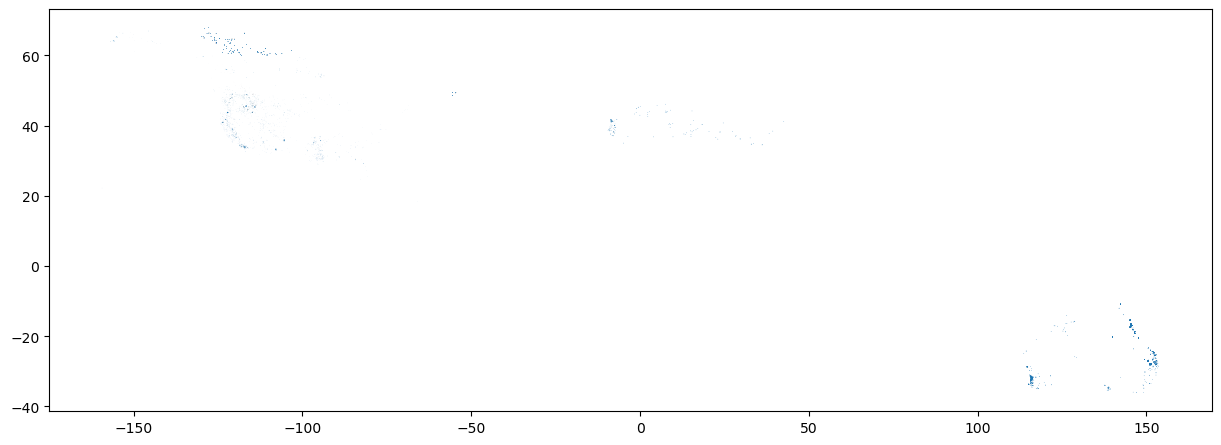

In [7]:
# drop duplicate data caused by merge of 24 x hourly LS gpkg files into a single daily geodataframe

gdf_LS_drop_duplicates = gdf_LS.sort_values('SourceEventId').drop_duplicates(['SourceId', 'SourceEventId', 'SourceLastUpdated'])
# gdf_LS_drop_duplicates = gdf_LS.sort_values('SourceEventId')

# reset the gdf index
gdf_LS_drop_duplicates.reset_index(inplace = True, drop = True)

print('\n[gdf_LS_drop_duplicates.is_valid]:')
print(gdf_LS_drop_duplicates.is_valid.all())
print('\n[gdf_LS_drop_duplicates type]:')
print(type(gdf_LS_drop_duplicates))
print('\n[gdf_LS_drop_duplicates]:')
print(gdf_LS_drop_duplicates)

# create a plot of the GDF
gdf_LS_drop_duplicates.plot(figsize=(15,15))


[gdf_LS_notna_geom.is_valid]:
False

[gdf_LS_notna_geom type]:
<class 'geopandas.geodataframe.GeoDataFrame'>

[gdf_LS_notna_geom]:
                                               geometry      SourceId  \
0     POLYGON ((-115.55885 46.87775, -115.55898 46.8...       IRW_USA   
1     POLYGON ((-112.99385 47.07584, -112.99398 47.0...       IRW_USA   
2     POLYGON ((-117.19614 33.77934, -117.19627 33.7...       IRW_USA   
3     POLYGON ((-120.08342 36.88028, -120.08355 36.8...       IRW_USA   
4     POLYGON ((-96.41999 42.14806, -96.42012 42.146...       IRW_USA   
...                                                 ...           ...   
6214  POLYGON ((-116.43265 44.09399, -116.43278 44.0...       IRW_USA   
6215  POLYGON ((-116.42528 44.09102, -116.42530 44.0...  IRW_NIFC_USA   
6216  POLYGON ((-116.42528 44.09102, -116.42530 44.0...  IRW_NIFC_USA   
6217  POLYGON ((-116.43265 44.09399, -116.43278 44.0...       IRW_USA   
6218  POLYGON ((-104.26884 41.91691, -104.26897 41.9...       IRW

<AxesSubplot:>

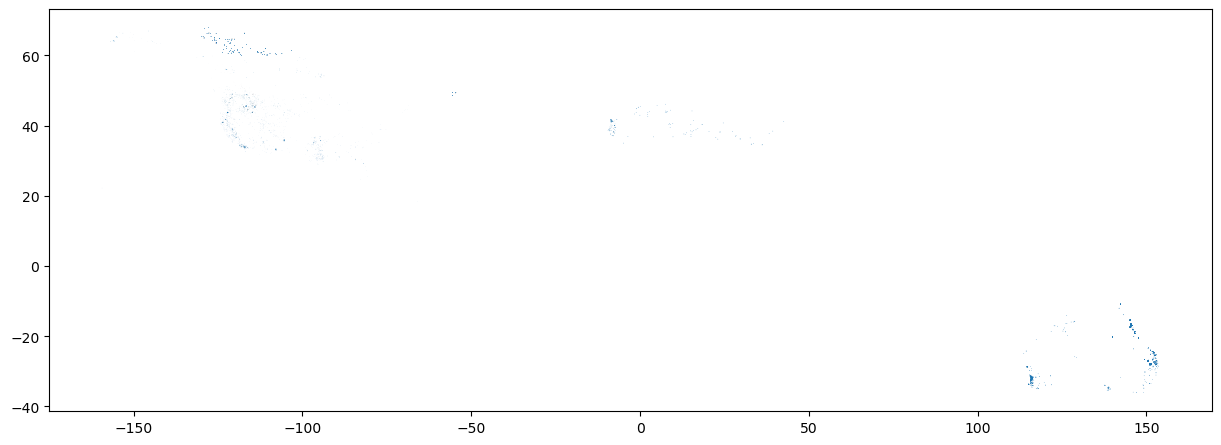

In [8]:
# search for events with no geometry and drop them

notna_mask = gdf_LS_drop_duplicates['geometry'].notna() # create a mask of events that have valid (not NULL) 'geometry' field
gdf_LS_notna_geom = gdf_LS_drop_duplicates[notna_mask] # use mask to filter events - only valid (not NULL) 'geometry' entries remain 

# reset the gdf index
gdf_LS_notna_geom.reset_index(inplace = True, drop = True)
gdf_LS_notna_geom

print('\n[gdf_LS_notna_geom.is_valid]:')
print(gdf_LS_notna_geom.is_valid.all())
print('\n[gdf_LS_notna_geom type]:')
print(type(gdf_LS_notna_geom))
print('\n[gdf_LS_notna_geom]:')
print(gdf_LS_notna_geom)

# create a plot of the GDF
gdf_LS_notna_geom.plot(figsize=(15,15))


[gdf_LS_notna_geom.is_valid after buffer(0)]:
False

[gdf_LS_notna_geom type]:
<class 'geopandas.geodataframe.GeoDataFrame'>

[gdf_LS_notna_geom]:
                                               geometry      SourceId  \
0     POLYGON ((-115.55885 46.87775, -115.55898 46.8...       IRW_USA   
1     POLYGON ((-112.99385 47.07584, -112.99398 47.0...       IRW_USA   
2     POLYGON ((-117.19614 33.77934, -117.19627 33.7...       IRW_USA   
3     POLYGON ((-120.08342 36.88028, -120.08355 36.8...       IRW_USA   
4     POLYGON ((-96.41999 42.14806, -96.42012 42.146...       IRW_USA   
...                                                 ...           ...   
6214  POLYGON ((-116.43265 44.09399, -116.43278 44.0...       IRW_USA   
6215  POLYGON ((-116.42528 44.09102, -116.42530 44.0...  IRW_NIFC_USA   
6216  POLYGON ((-116.42528 44.09102, -116.42530 44.0...  IRW_NIFC_USA   
6217  POLYGON ((-116.43265 44.09399, -116.43278 44.0...       IRW_USA   
6218  POLYGON ((-104.26884 41.91691, -104.26897 4

<AxesSubplot:>

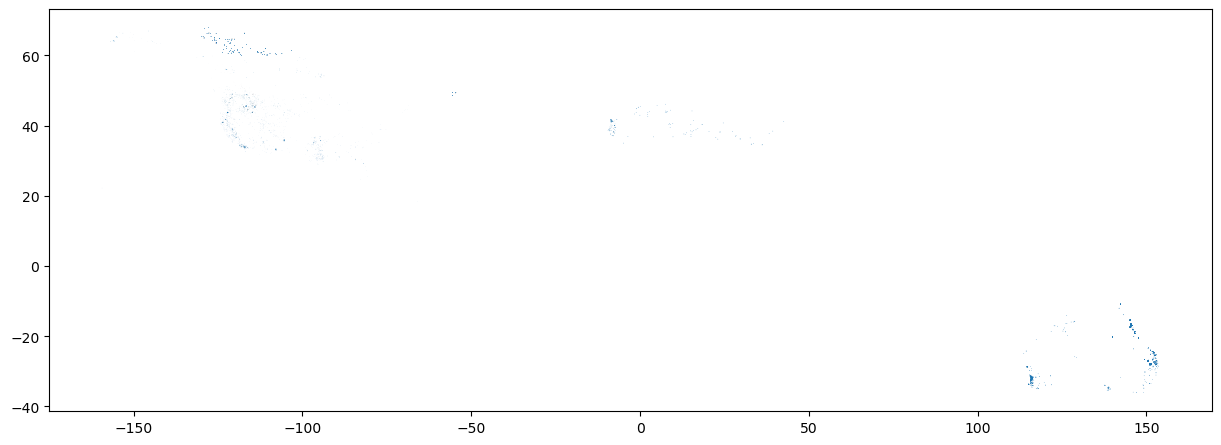

In [9]:
# this Buffer function is to try fix geometries

gdf_LS_notna_geom['geometry'].buffer(0).is_valid.all()

print('\n[gdf_LS_notna_geom.is_valid after buffer(0)]:')
print(gdf_LS_notna_geom.is_valid.all())
print('\n[gdf_LS_notna_geom type]:')
print(type(gdf_LS_notna_geom))
print('\n[gdf_LS_notna_geom]:')
print(gdf_LS_notna_geom)

# create a plot of the GDF
gdf_LS_notna_geom.plot(figsize=(15,15))

Check Geometry Progress Bar::   0%|          | 0/6219 [00:00<?, ?it/s]2022-11-02 19:11:27,558 [INFO]  Ring Self-intersection at or near point -118.327354 47.832751000000002
2022-11-02 19:11:27,560 [INFO]  Ring Self-intersection at or near point -118.327354 47.832751000000002
Check Geometry Progress Bar::   0%|          | 22/6219 [00:00<00:31, 199.34it/s]2022-11-02 19:11:27,588 [INFO]  Self-intersection at or near point -120.93894038888889 39.05504094444445
2022-11-02 19:11:27,589 [INFO]  Self-intersection at or near point -120.93894038888889 39.05504094444445
2022-11-02 19:11:27,592 [INFO]  Ring Self-intersection at or near point -114.99607 45.812548
2022-11-02 19:11:27,592 [INFO]  Ring Self-intersection at or near point -114.99607 45.812548
2022-11-02 19:11:27,599 [INFO]  Self-intersection at or near point -112.425403 34.383941999999998
2022-11-02 19:11:27,600 [INFO]  Self-intersection at or near point -112.425403 34.383941999999998
2022-11-02 19:11:27,622 [INFO]  Ring Self-intersecti



[gdf_LS_valid_geom.is_valid]:
True

[gdf_LS_valid_geom type]:
<class 'geopandas.geodataframe.GeoDataFrame'>

[gdf_LS_valid_geom]:
                                               geometry      SourceId  \
0     POLYGON ((-115.55885 46.87775, -115.55898 46.8...       IRW_USA   
1     POLYGON ((-112.99385 47.07584, -112.99398 47.0...       IRW_USA   
2     POLYGON ((-117.19614 33.77934, -117.19627 33.7...       IRW_USA   
3     POLYGON ((-120.08342 36.88028, -120.08355 36.8...       IRW_USA   
4     POLYGON ((-96.41999 42.14806, -96.42012 42.146...       IRW_USA   
...                                                 ...           ...   
6214  POLYGON ((-116.43265 44.09399, -116.43278 44.0...       IRW_USA   
6215  POLYGON ((-116.42528 44.09102, -116.42530 44.0...  IRW_NIFC_USA   
6216  POLYGON ((-116.42528 44.09102, -116.42530 44.0...  IRW_NIFC_USA   
6217  POLYGON ((-116.43265 44.09399, -116.43278 44.0...       IRW_USA   
6218  POLYGON ((-104.26884 41.91691, -104.26897 41.9...       IRW

<AxesSubplot:>

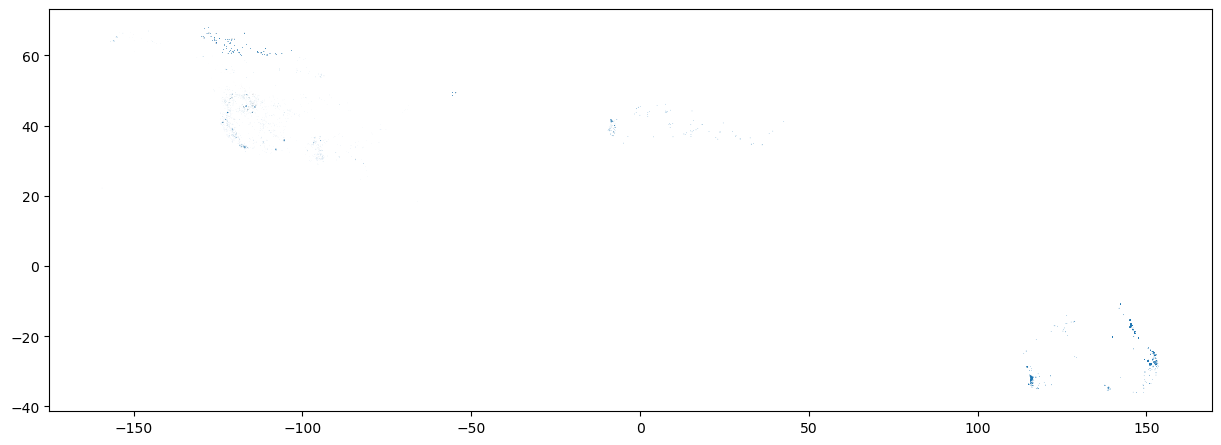

In [10]:
# fix the geometries with shapely make_valid function

tqdm.pandas(desc="Check Geometry Progress Bar:", position=0, leave=True, colour="blue")
gdf_LS_notna_geom.geometry = gdf_LS_notna_geom.progress_apply(lambda row: make_valid(row.geometry) if not row.geometry.is_valid else row.geometry, axis=1)
gdf_LS_valid_geom = gdf_LS_notna_geom

print('\n\n[gdf_LS_valid_geom.is_valid]:')
print(gdf_LS_valid_geom.is_valid.all())
print('\n[gdf_LS_valid_geom type]:')
print(type(gdf_LS_valid_geom))
print('\n[gdf_LS_valid_geom]:')
print(gdf_LS_valid_geom)

# create a plot of the GDF
gdf_LS_valid_geom.plot(figsize=(15,15))



[gdf_LS_valid_geom_comparedatetime.is_valid]:
True

[gdf_LS_valid_geom_comparedatetime type]:
<class 'geopandas.geodataframe.GeoDataFrame'>

[gdf_LS_valid_geom_comparedatetime]:
                                               geometry      SourceId  \
0     POLYGON ((-115.55885 46.87775, -115.55898 46.8...       IRW_USA   
1     POLYGON ((-112.99385 47.07584, -112.99398 47.0...       IRW_USA   
2     POLYGON ((-117.19614 33.77934, -117.19627 33.7...       IRW_USA   
3     POLYGON ((-120.08342 36.88028, -120.08355 36.8...       IRW_USA   
4     POLYGON ((-96.41999 42.14806, -96.42012 42.146...       IRW_USA   
...                                                 ...           ...   
6214  POLYGON ((-116.43265 44.09399, -116.43278 44.0...       IRW_USA   
6215  POLYGON ((-116.42528 44.09102, -116.42530 44.0...  IRW_NIFC_USA   
6216  POLYGON ((-116.42528 44.09102, -116.42530 44.0...  IRW_NIFC_USA   
6217  POLYGON ((-116.43265 44.09399, -116.43278 44.0...       IRW_USA   
6218  POLYGON ((-

<AxesSubplot:>

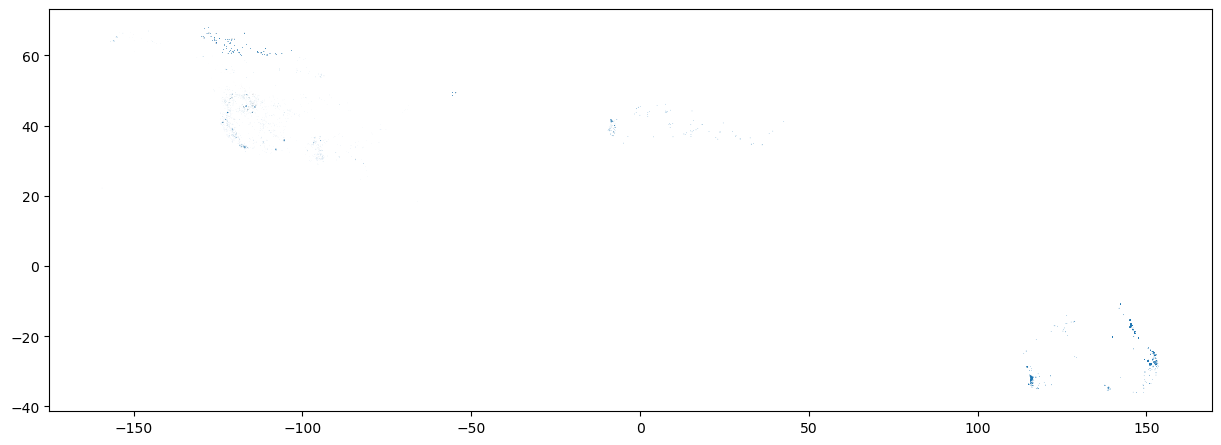

In [11]:
# Add geodataframe column for CompareDateTime
# if DiscoveryDateTime is NULL then use CreatedOnDateTime
# if CreatedOnDateTime is NULL then use LastUpdated

gdf_LS_valid_geom["CompareDateTime"] = gdf_LS_valid_geom["SourceDiscoveryDateTime"].fillna(gdf_LS_valid_geom["SourceCreatedOnDateTime"].fillna(gdf_LS_valid_geom["SourceLastUpdated"]))
gdf_LS_valid_geom_comparedatetime = gdf_LS_valid_geom

print('\n\n[gdf_LS_valid_geom_comparedatetime.is_valid]:')
print(gdf_LS_valid_geom_comparedatetime.is_valid.all())
print('\n[gdf_LS_valid_geom_comparedatetime type]:')
print(type(gdf_LS_valid_geom_comparedatetime))
print('\n[gdf_LS_valid_geom_comparedatetime]:')
print(gdf_LS_valid_geom_comparedatetime)

# create a plot of the GDF
gdf_LS_valid_geom_comparedatetime.plot(figsize=(15,15))



[gdf_LS_temporal_buffer.is_valid]:
True

[gdf_LS_temporal_buffer type]:
<class 'geopandas.geodataframe.GeoDataFrame'>

[gdf_LS_temporal_buffer]:
                                               geometry      SourceId  \
0     POLYGON ((-115.55885 46.87775, -115.55898 46.8...       IRW_USA   
1     POLYGON ((-112.99385 47.07584, -112.99398 47.0...       IRW_USA   
2     POLYGON ((-117.19614 33.77934, -117.19627 33.7...       IRW_USA   
3     POLYGON ((-120.08342 36.88028, -120.08355 36.8...       IRW_USA   
4     POLYGON ((-96.41999 42.14806, -96.42012 42.146...       IRW_USA   
...                                                 ...           ...   
6214  POLYGON ((-116.43265 44.09399, -116.43278 44.0...       IRW_USA   
6215  POLYGON ((-116.42528 44.09102, -116.42530 44.0...  IRW_NIFC_USA   
6216  POLYGON ((-116.42528 44.09102, -116.42530 44.0...  IRW_NIFC_USA   
6217  POLYGON ((-116.43265 44.09399, -116.43278 44.0...       IRW_USA   
6218  POLYGON ((-104.26884 41.91691, -104.26897 41

<AxesSubplot:>

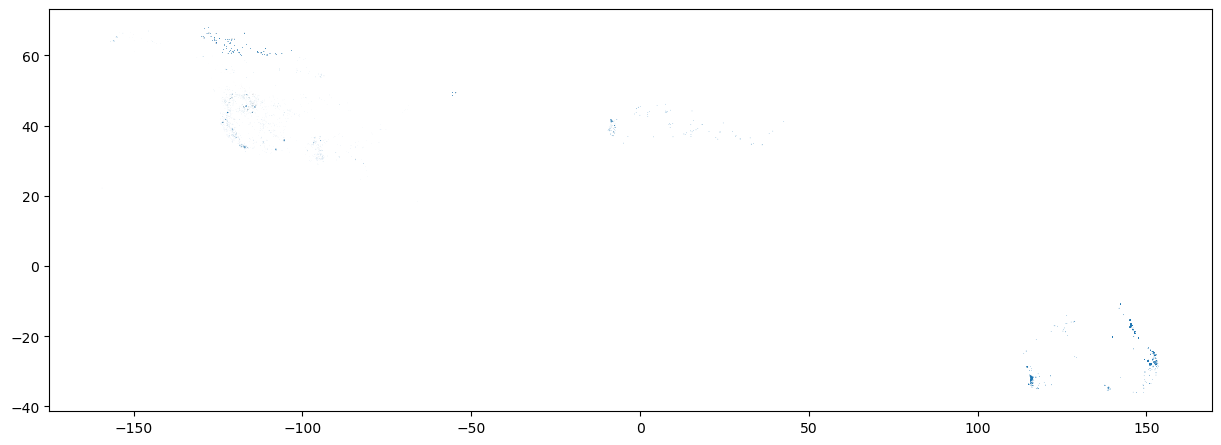

In [12]:
# add buffer of 7-days to CompareDateTime
td = pd.Timedelta(7, 'd')
td

gdf_LS_valid_geom_comparedatetime['minCompareDateTime'] = pd.to_datetime(gdf_LS_valid_geom_comparedatetime['CompareDateTime']) - td
gdf_LS_valid_geom_comparedatetime['maxCompareDateTime'] = pd.to_datetime(gdf_LS_valid_geom_comparedatetime['CompareDateTime']) + td

gdf_LS_temporal_buffer = gdf_LS_valid_geom_comparedatetime

gdf_LS_temporal_buffer.set_geometry('geometry', crs=4326)

print('\n\n[gdf_LS_temporal_buffer.is_valid]:')
print(gdf_LS_temporal_buffer.is_valid.all())
print('\n[gdf_LS_temporal_buffer type]:')
print(type(gdf_LS_temporal_buffer))
print('\n[gdf_LS_temporal_buffer]:')
print(gdf_LS_temporal_buffer)

# create a plot of the GDF
gdf_LS_temporal_buffer.plot(figsize=(15,15))



[gdf_LS_temporal_filter.is_valid]:
True

[gdf_LS_temporal_filter type]:
<class 'geopandas.geodataframe.GeoDataFrame'>

[gdf_LS_temporal_filter]:
                                               geometry      SourceId  \
0     POLYGON ((-112.99385 47.07584, -112.99398 47.0...       IRW_USA   
1     POLYGON ((-117.19614 33.77934, -117.19627 33.7...       IRW_USA   
2     POLYGON ((-120.08342 36.88028, -120.08355 36.8...       IRW_USA   
3     POLYGON ((-96.41999 42.14806, -96.42012 42.146...       IRW_USA   
4     POLYGON ((-109.33055 38.00697, -109.33068 38.0...       IRW_USA   
...                                                 ...           ...   
3059  POLYGON ((-116.43265 44.09399, -116.43278 44.0...       IRW_USA   
3060  POLYGON ((-116.42528 44.09102, -116.42530 44.0...  IRW_NIFC_USA   
3061  POLYGON ((-116.42528 44.09102, -116.42530 44.0...  IRW_NIFC_USA   
3062  POLYGON ((-116.43265 44.09399, -116.43278 44.0...       IRW_USA   
3063  POLYGON ((-104.26884 41.91691, -104.26897 41

<AxesSubplot:>

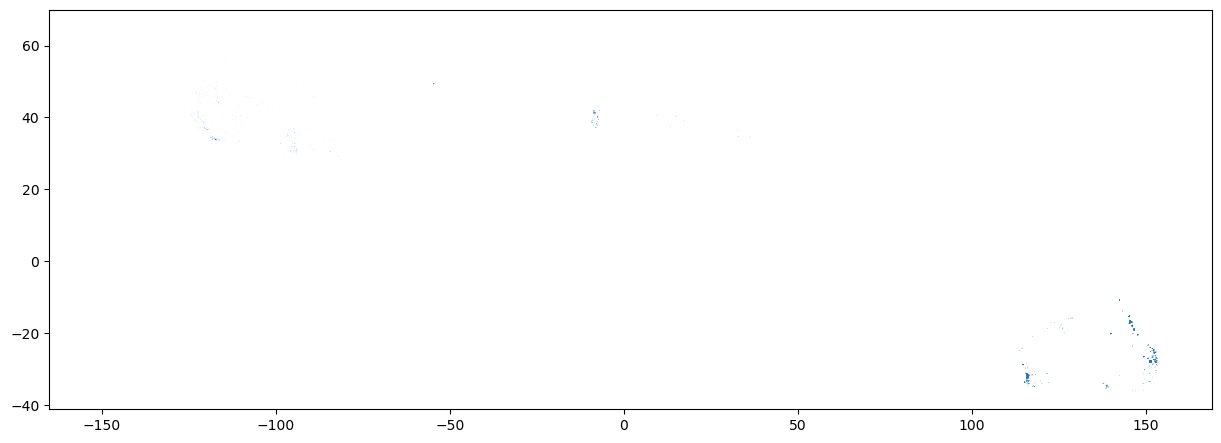

In [13]:
# Search for events with CompareDateTime more than 7-days 'td' before current 'ts' and drop them
# These events should be reports in the approrpiate 'ts'

gdf_LS_temporal_filter = pd.DataFrame()
gdf_LS_temporal_filter = gdf_LS_temporal_buffer.copy()
# print('\n\n[gdf_LS_temporal_filter.type]:')
# print(type(gdf_LS_temporal_filter))
# print('\n[gdf_LS_temporal_filter.is_valid]:')
# print(gdf_LS_temporal_filter.is_valid.all())
# print('\n[gdf_LS_temporal_filter]:')
# print(gdf_LS_temporal_filter)

gdf_LS_temporal_filter = gdf_LS_temporal_filter[pd.to_datetime(gdf_LS_temporal_filter['ts']) - pd.to_datetime(gdf_LS_temporal_filter['CompareDateTime']) <= td] 

# reset the gdf index
gdf_LS_temporal_filter.reset_index(inplace = True, drop = True)

print('\n\n[gdf_LS_temporal_filter.is_valid]:')
print(gdf_LS_temporal_filter.is_valid.all())
print('\n[gdf_LS_temporal_filter type]:')
print(type(gdf_LS_temporal_filter))
print('\n[gdf_LS_temporal_filter]:')
print(gdf_LS_temporal_filter)

# create a plot of the GDF
gdf_LS_temporal_filter.plot(figsize=(15,15))

In [14]:
# Create new GDF group for each LS -> Union overlapping shapes -> Dissolve duplicate EventId -> Append to new GDF (dissolve) output

# create new empty GDF
gdf_LS_dissolve = pd.DataFrame()

# group data in geodataframe into LS SourceId 'buckets'
gdf_grouped_SourceId = gdf_LS_temporal_filter.groupby(by='SourceId')

# get the number of unique local sources for progress bar
num_LS = gdf_LS_temporal_filter.nunique()
# print('\n', num_LS)
# print('\n', num_LS.SourceId)

# setup progress bar for total progress
pbar_total = tqdm(total=num_LS.SourceId, desc="Total Progress:", position=0, leave=True, colour="red")

for name, current_gdf_SourceId_group in gdf_grouped_SourceId:
    
    # print('\n\n[current_gdf_SourceId_group type]:')
    # print(type(current_gdf_SourceId_group))
    # print('\n[current_gdf_SourceId_group.is_valid]:')
    # print(current_gdf_SourceId_group.is_valid.all())
    # print('\n[current_gdf_SourceId_group]:')
    # print(current_gdf_SourceId_group)

    # Dissolve shape geometries in GDF based on their spatial overlap (for each LS in turn)
    # create a temporary GDF based on unary_union of all shape geometries in the input GDF (will create a single dissolved multi-polygon) and then explode these shapes into their individual components
    gdf_LS_dissolve_geom_tmp = gpd.GeoDataFrame(geometry=[current_gdf_SourceId_group.unary_union]).explode(index_parts=False).reset_index(drop=True)

    # set CRS of temporary GDF
    gdf_LS_dissolve_geom_tmp = gdf_LS_dissolve_geom_tmp.set_crs("EPSG:4326")

    # join attributes of input GDF to temporary GDF based on a spatial join.
    gdf_LS_dissolve_geom_tmp = gpd.sjoin(gdf_LS_dissolve_geom_tmp, current_gdf_SourceId_group, how='left').drop(columns=['index_right'])

    # dissolve based on GDF index to ensure no duplicates
    gdf_LS_dissolve_geom_tmp.dissolve(gdf_LS_dissolve_geom_tmp.index, aggfunc='first')

    # print('\n\n[gdf_LS_dissolve_geom_tmp type -> after geometry union, explode, sjoin]:')
    # print(type(gdf_LS_dissolve_geom_tmp))
    # print('\n[gdf_LS_dissolve_geom_tmp.is_valid -> after geometry union, explode, sjoin]:')
    # print(gdf_LS_dissolve_geom_tmp.is_valid.all())
    # print('\n[gdf_LS_dissolve_geom_tmp -> after geometry union, explode, sjoin]:')
    # print(gdf_LS_dissolve_geom_tmp)

    # Dissolve shapes with same UniqueSourceEventId
    attrs = ["UniqueSourceEventId"]
    gdf_LS_dissolve_geom_tmp = gdf_LS_dissolve_geom_tmp.dissolve(by=attrs, aggfunc='last', as_index=False)

    # print('\n\n[gdf_LS_dissolve_geom_tmp type -> after dissolve by UniqueSourceId]:')
    # print(type(gdf_LS_dissolve_geom_tmp))
    # print('\n[gdf_LS_dissolve_geom_tmp.is_valid -> after dissolve by UniqueSourceId]:')
    # print(gdf_LS_dissolve_geom_tmp.is_valid.all())
    # print('\n[gdf_LS_dissolve_geom_tmp -> after dissolve by UniqueSourceId]:')
    # print(gdf_LS_dissolve_geom_tmp)
    
    # check for identical geometries and drop them from GDF *** KEEP LAST RECORD
    # make a string column for the WKT geom - for the groupby function
    gdf_LS_dissolve_geom_tmp['WKT'] = gdf_LS_dissolve_geom_tmp['geometry'].apply(lambda x: str(x))

    # print('\n\n[gdf_LS_dissolve_geom_tmp type]:')
    # print(type(gdf_LS_dissolve_geom_tmp))
    # print('\n[gdf_LS_dissolve_geom_tmp.is_valid]:')
    # print(gdf_LS_dissolve_geom_tmp.is_valid.all())
    # print('\n[gdf_LS_dissolve_geom_tmp]:')
    # print(gdf_LS_dissolve_geom_tmp)
    
    # group GDF by WKT of 'duplicate' geometries and select the LAST entry from the 'duplicate' attributes *** NEED TO BE ABLE TO SELECT LAST FROM 'ts'
    # grouped_gdf_LS_dissolve_geom_tmp = gdf_LS_dissolve_geom_tmp.groupby(by='WKT')['CompareDateTime'].last().reset_index()
    
    # sort data by 'CompareDateTime' to get most recent datetime -> group GDF by WKT of 'duplicate' geometries and select the LAST entry from the 'duplicate' attributes
    grouped_gdf_LS_dissolve_geom_tmp = gdf_LS_dissolve_geom_tmp.sort_values(['CompareDateTime'], ascending=[False]).groupby(by='WKT').head(1).reset_index()
        
    # print('\n\n[grouped_gdf_LS_dissolve_geom_tmp type]:')
    # print(type(grouped_gdf_LS_dissolve_geom_tmp))
    # print('\n[grouped_gdf_LS_dissolve_geom_tmp]:')
    # print(grouped_gdf_LS_dissolve_geom_tmp)
    
    # result_gdf_LS_dissolve_geom_tmp  = grouped_gdf_LS_dissolve_geom_tmp[['WKT', 'SourceId', 'SourceName', 'SourceURL', 'SourceEventId', 'SourceEventName', 'SourceEventDescription', 'SourceLastUpdated', 'SourceDiscoveryDateTime', 'SourceCreatedOnDateTime', 'SourcePercentContained', 'SourceContainmentForecast', 'SourceInitialLatitude', 'SourceInitialLongitude', 'SourceCurrentLatitude', 'SourceCurrentLongitude', 'SourceDetailURL', 'SourceDetailURLName', 'ComplexName', 'SourcePrescribed', 'DailyAcres', 'UniqueSourceEventId', 'ts', 'CompareDateTime', 'minCompareDateTime', 'maxCompareDateTime']]
    # result_gdf_LS_dissolve_geom_tmp  = grouped_gdf_LS_dissolve_geom_tmp[['WKT']]
    result_gdf_LS_dissolve_geom_tmp  = grouped_gdf_LS_dissolve_geom_tmp
    
    # then rebuild geometry from WKT
    result_gdf_LS_dissolve_geom_tmp['geometry'] = result_gdf_LS_dissolve_geom_tmp['WKT'].apply(lambda x: loads(x))
    result_gdf_LS_dissolve_geom_tmp = gpd.GeoDataFrame(result_gdf_LS_dissolve_geom_tmp, crs=4326)
    
    # print('\n\n[result_gdf_LS_dissolve_geom_tmp type]:')
    # print(type(result_gdf_LS_dissolve_geom_tmp))
    # print('\n[result_gdf_LS_dissolve_geom_tmp.is_valid]:')
    # print(result_gdf_LS_dissolve_geom_tmp.is_valid.all())
    # print('\n[result_gdf_LS_dissolve_geom_tmp]:')
    # print(result_gdf_LS_dissolve_geom_tmp)

    # print('\n\n[gdf_LS_dissolve_geom_tmp type -> after drop duplicates]:')
    # print(type(gdf_LS_dissolve_geom_tmp))
    # print('\n[gdf_LS_dissolve_geom_tmp.is_valid -> after drop duplicates]:')
    # print(gdf_LS_dissolve_geom_tmp.is_valid.all())
    # print('\n[gdf_LS_dissolve_geom_tmp -> after drop duplicates]:')
    # print(gdf_LS_dissolve_geom_tmp)

    # append data for each local source into new dissolve GDF
    # gdf_LS_dissolve = gdf_LS_dissolve.append(gdf_LS_dissolve_geom_tmp)
    gdf_LS_dissolve = gdf_LS_dissolve.append(result_gdf_LS_dissolve_geom_tmp)

    # update progress bars
    pbar_total.update(1)
    
    # input("Press Enter to continue...")
    
pbar_total.close()

# Drop WKT column
gdf_LS_dissolve.drop('index', axis=1, inplace=True) 

# reset the gdf index
gdf_LS_dissolve.reset_index(inplace = True, drop = True)

print('\n\n[gdf_LS_dissolve type]:')
print(type(gdf_LS_dissolve))
print('\n[gdf_LS_dissolve.is_valid]:')
print(gdf_LS_dissolve.is_valid.all())
print('\n[gdf_LS_dissolve]:')
print(gdf_LS_dissolve)

Total Progress:: 100%|██████████| 10/10 [00:06<00:00,  1.60it/s]



[gdf_LS_dissolve type]:
<class 'geopandas.geodataframe.GeoDataFrame'>

[gdf_LS_dissolve.is_valid]:
True

[gdf_LS_dissolve]:
     UniqueSourceEventId                                           geometry  \
0          BC_CAN_N11064  POLYGON ((-115.66237 49.09938, -115.66212 49.0...   
1          BC_CAN_N12113  POLYGON ((-116.54033 49.75581, -116.54017 49.7...   
2          BC_CAN_N40903  POLYGON ((-117.88657 50.84571, -117.88651 50.8...   
3          BC_CAN_N41683  POLYGON ((-118.28732 51.58100, -118.28730 51.5...   
4          BC_CAN_N41684  POLYGON ((-118.31727 51.58996, -118.31721 51.5...   
...                  ...                                                ...   
1130     WAFS_AUS_590291  POLYGON ((125.51143 -18.07409, 125.50435 -18.0...   
1131     WAFS_AUS_590011  POLYGON ((115.82528 -31.14101, 115.81875 -31.1...   
1132     WAFS_AUS_589866  POLYGON ((123.76099 -17.22434, 123.75391 -17.2...   
1133     WAFS_AUS_589832  POLYGON ((122.71675 -17.08154, 122.70967 -17.0...   
1134 

In [15]:
# view drivers availbale to export geodataframe

# fiona.supported_drivers

In [16]:
# view geodataframe coordinate system

# gdf_LS_explode.crs



[gdf_LS_spatial_bounds]:
<class 'geopandas.geodataframe.GeoDataFrame'>

[gdf_LS_spatial_bounds]:
True

[gdf_LS_spatial_bounds]:
     UniqueSourceEventId                                           geometry  \
0          BC_CAN_N11064  POLYGON ((-115.66237 49.09938, -115.66212 49.0...   
1          BC_CAN_N12113  POLYGON ((-116.54033 49.75581, -116.54017 49.7...   
2          BC_CAN_N40903  POLYGON ((-117.88657 50.84571, -117.88651 50.8...   
3          BC_CAN_N41683  POLYGON ((-118.28732 51.58100, -118.28730 51.5...   
4          BC_CAN_N41684  POLYGON ((-118.31727 51.58996, -118.31721 51.5...   
...                  ...                                                ...   
1130     WAFS_AUS_590291  POLYGON ((125.51143 -18.07409, 125.50435 -18.0...   
1131     WAFS_AUS_590011  POLYGON ((115.82528 -31.14101, 115.81875 -31.1...   
1132     WAFS_AUS_589866  POLYGON ((123.76099 -17.22434, 123.75391 -17.2...   
1133     WAFS_AUS_589832  POLYGON ((122.71675 -17.08154, 122.70967 -17.0...   
1

<AxesSubplot:>

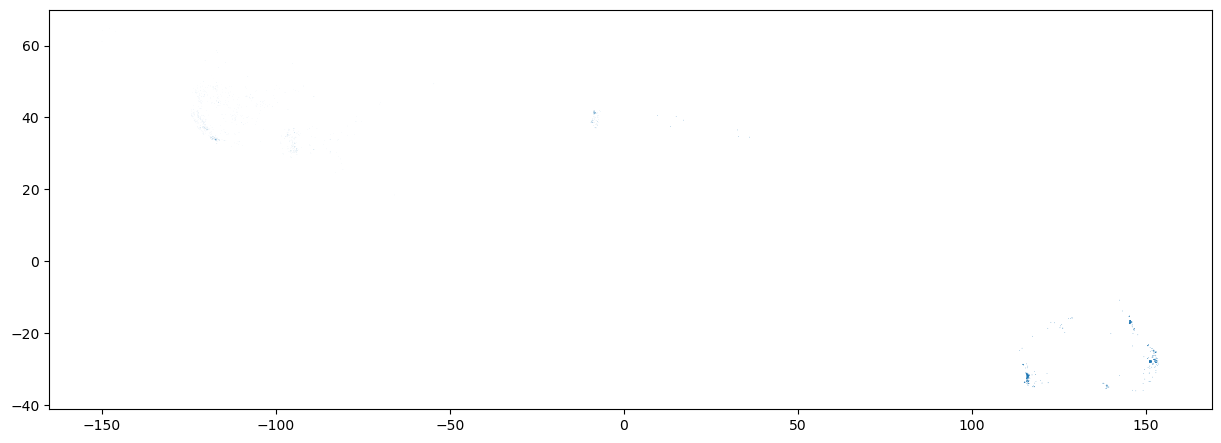

In [17]:
# adding min/max lat/long for each shape geometry to geodataframe
# include buffer of 1/4-degree for comparison search 
# 1/4-degree latitude is ~10km (@ 70-deg N/S) and ~27km (@ equator)
# 1/4-degree longitude is ~27km (@ 70-deg N/S and @ equator)

def get_bounds(r):
    minx, miny, maxx, maxy =  r["geometry"].bounds    
    r["minlong"] = minx - 0.25
    r["minlat"] = miny - 0.25
    r["maxlong"] = maxx + 0.25
    r["maxlat"] = maxy + 0.25
    return r
    
gdf_LS_spatial_bounds = gdf_LS_dissolve.apply(get_bounds, axis=1)

print('\n\n[gdf_LS_spatial_bounds]:')
print(type(gdf_LS_spatial_bounds))
print('\n[gdf_LS_spatial_bounds]:')
print(gdf_LS_spatial_bounds.is_valid.all())
print('\n[gdf_LS_spatial_bounds]:')
print(gdf_LS_spatial_bounds)

# create a plot of the GDF
gdf_LS_spatial_bounds.plot(figsize=(15,15))

In [18]:
# Drop LINESTRING features
gdf_LS_spatial_bounds.drop(gdf_LS_spatial_bounds.index[gdf_LS_spatial_bounds['WKT'].str.contains('LINESTRING')], inplace=True)

print('\n\n[gdf_LS_spatial_bounds - drop LINESTRING]:')
print(type(gdf_LS_spatial_bounds))
print('\n[gdf_LS_spatial_bounds - drop LINESTRING]:')
print(gdf_LS_spatial_bounds.is_valid.all())
print('\n[gdf_LS_spatial_bounds - drop LINESTRING]:')
print(gdf_LS_spatial_bounds)



[gdf_LS_spatial_bounds - drop LINESTRING]:
<class 'geopandas.geodataframe.GeoDataFrame'>

[gdf_LS_spatial_bounds - drop LINESTRING]:
True

[gdf_LS_spatial_bounds - drop LINESTRING]:
     UniqueSourceEventId                                           geometry  \
0          BC_CAN_N11064  POLYGON ((-115.66237 49.09938, -115.66212 49.0...   
1          BC_CAN_N12113  POLYGON ((-116.54033 49.75581, -116.54017 49.7...   
2          BC_CAN_N40903  POLYGON ((-117.88657 50.84571, -117.88651 50.8...   
3          BC_CAN_N41683  POLYGON ((-118.28732 51.58100, -118.28730 51.5...   
4          BC_CAN_N41684  POLYGON ((-118.31727 51.58996, -118.31721 51.5...   
...                  ...                                                ...   
1130     WAFS_AUS_590291  POLYGON ((125.51143 -18.07409, 125.50435 -18.0...   
1131     WAFS_AUS_590011  POLYGON ((115.82528 -31.14101, 115.81875 -31.1...   
1132     WAFS_AUS_589866  POLYGON ((123.76099 -17.22434, 123.75391 -17.2...   
1133     WAFS_AUS_589832  

In [19]:
# EXPLORE GEODATAFRAME

# drop timestamp columns (as they are not JSON serializable and explore() is based on folium/leaflet.js and uses GeoJSON formated data) and explore GDF
gdf_tmp = gdf_LS_spatial_bounds.copy()
gdf_tmp = gdf_tmp.drop(['SourceLastUpdated', 'SourceDiscoveryDateTime', 'SourceCreatedOnDateTime', 'ts', 'CompareDateTime', 'minCompareDateTime', 'maxCompareDateTime'], axis=1)

gdf_tmp.explore(location=[39.5, -6], zoom_start=6, tiles='openstreetmap') # centred on Portugal/Spain as a start location

In [20]:
# Drop WKT column
gdf_LS_spatial_bounds.drop('WKT', axis=1, inplace=True) 

In [21]:
# Add 'index' column
gdf_LS_spatial_bounds['gdf_index'] = gdf_LS_spatial_bounds.index

In [22]:
# Set start_ and end_ datetime variables for output file naming
start_datetime = gdf_LS_spatial_bounds.ts.min()
end_datetime = gdf_LS_spatial_bounds.ts.max()

In [23]:
# Export GeoDataFrame

gdf_LS_spatial_bounds.to_file(f"gdf_LS_spatial_bounds_{start_datetime}_{end_datetime}.geojson", driver='GeoJSON')
gdf_LS_spatial_bounds.to_file(f"gdf_LS_spatial_bounds_{start_datetime}_{end_datetime}.gpkg", driver='GPKG')

In [24]:
# Export GeoDataFrame to CSV using Pandas (beause Geopandas export to CSV giving errors)

tqdm.pandas(desc="CSV Export Progress Bar:")
pd.DataFrame(gdf_LS_spatial_bounds.assign(geometry=gdf_LS_dissolve["geometry"].progress_apply(lambda p: p.wkt))).to_csv(f"gdf_LS_spatial_bounds_{start_datetime}_{end_datetime}.csv")

CSV Export Progress Bar:: 100%|██████████| 1135/1135 [00:00<00:00, 14669.15it/s]
/opt/conda/lib/python3.7/site-packages/geopandas/geodataframe.py:1350: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")
